# Простые эксперименты с прунингом

Импорт библиотек.

In [1]:
!pip install torcheval -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.5 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
from torch.fx import symbolic_trace
from torchvision import models
import torch.utils.data
import torchvision
from torchvision import transforms
from torcheval.metrics import BinaryAUROC

import numpy as np
from scipy.stats import spearmanr, kendalltau

from typing import Callable, List, Tuple
from functools import reduce, partial
import re
import copy

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import networkx

sns.set_style('darkgrid')

## Реализация модулей

Графовые представления сетей.

In [3]:
class Gamma(torch.nn.Module):
    def __init__(self, initial_gamma = 0.0) -> None:
        super().__init__()
        self.param = torch.nn.Parameter(torch.tensor(initial_gamma))
        self.discrete = False 
    
    def make_discrete(self):
        raise NotImplementedError()

    def forward(self):
        return self.param  
    
class SigmoidGamma(Gamma):
    def make_discrete(self):
        self.discrete = True 
        self.param.requires_grad = False 

    def forward(self):
        if self.discrete:
            return 1.0 * (self.param)
        else:
            return torch.sigmoid(self.param)

        
def get_module_by_name(module,
                       access_string: str):
    """Retrieve a module nested in another by its access string.

    Works even when there is a Sequential in the module.
    """
    names = access_string.split(sep='.')
    return reduce(getattr, names, module)
  
def gamma_hook(module, inp, out, gamma,  intermediate_dict, proper2real_label, real2proper_label, label, proper_label):
    result = out * gamma()
    intermediate_dict[proper_label] = result  # activation

    # Hook for gradient
    def save_grad(grad):
        module.grad_out = grad.detach().cpu().clone()
    result.register_hook(save_grad)

    proper2real_label[proper_label] = label 
    real2proper_label[label] = proper_label

    return result 

def make_gamma_hooks(module: torch.nn.Module, graph_module, gamma_constructor: Callable):
    node2node = {}
    for node in graph_module.graph.nodes:
      for node2 in node.all_input_nodes:
        if node2 not in node2node:
          node2node[node2] = []
        node2node[node2].append(node)


    modified = True
    while modified:
      modified = False 
      for node in node2node:
        to_del = set()
        for i in range(len(node2node[node])):
          if node2node[node][i].op != 'call_module':
            modified = True
            to_del.add(node2node[node][i])
            if node2node[node][i] in node2node: # check that not output
              node2node[node].extend(node2node[node2node[node][i]])
          for node2 in to_del:
            node2node[node].remove(node2)
            
    to_del = set()
    to_change = set()

    for node in node2node:
      if node.op != 'call_module':
        to_del.add(node)
      else:
        to_change.add(node)
    for node in to_del:
      del node2node[node]  
    for node in to_change:
      new_result = [str(node2.target).replace('.', '_') for node2 in node2node[node]]
      node2node[str(node.target).replace('.', '_')] = new_result
      del node2node[node]
    for node in graph_module.graph.nodes:
        if node.op == "call_module":
            tgt = node.target.replace('.', '_')
            if (tgt not in node2node) or (len(node2node[tgt]) == 0):
          
                print (str(node), 'output')
                node2node[str(node)] = ['output']
    module.node2node = node2node
    
    nodes = set()

    
    for node in graph_module.graph.nodes:
        #print (node.target, node.op)
        if node.op == "call_module":
            nodes.add(node.target)
    
    module.gammas = []
    module.intermediate = {}
    module.proper2real_label = {}
    module.real2proper_label = {}

    for node in nodes:
        submodule = get_module_by_name(module, node)
        new_gamma = gamma_constructor()
        node_intermediate_name = str(node)
        node_propper_name = str(node_intermediate_name.replace('.', '_'))
        
        submodule.add_module(f'gamma_{node_propper_name}', new_gamma)
        submodule.register_forward_hook(partial(gamma_hook, gamma = new_gamma, intermediate_dict = module.intermediate,
                                                label = node_intermediate_name, 
                                                proper2real_label = module.proper2real_label,
                                                  real2proper_label = module.real2proper_label,
                                                    proper_label = node_propper_name))
        for param in new_gamma.parameters():
            module.gammas.append(param)

def make_graph_description(graph_module, operations = None):
    nonwords = re.compile('[^A-Za-z0-9\s]+')
    if operations is None:
        operations = ['call_module']

    e = {}
    for node in graph_module.graph.nodes:
        if node.op in operations:
            #почему-то аргументы идут с нижним подчеркивание вместо точки
            in_ = nonwords.sub('.', node.name)
            e[(in_,  node.op)] = []
            for out_ in list(node.args) + list(node.kwargs):
                #print (str(out_), nonwords.sub(' ', str(out_)))
                try:
                    out_ = nonwords.sub('.', out_.name)
                except:
                    out_ = nonwords.sub('.', str(out_))
               
                e[(in_,  node.op)].append((out_))
    return e 

def networkx_plot_graph(graph_module, operations=None):
    try:
        import networkx as nx 
    except:
        print ('install networkx')
        return 
    if operations is None:
        operations = ['call_module']

    e = make_graph_description(graph_module, operations=operations)
    color_map = ['b', 'g', 'r']
    
    graph = nx.DiGraph()
    vert_colors = {}
    for in_ in e:
        in_, op = in_ 
        vert_colors[in_] = color_map[operations.index(op)]
        
        for out_ in e[(in_, op)]:
            graph.add_edge(out_, in_)
    vert_color_list = []
    for node in graph.nodes:
        vert_color_list.append(vert_colors.get(node, 'gray'))

    return graph, vert_color_list 

Данные.

In [4]:
def get_dataloaders(classes: List[int], batch_size: int = 16, img_size: int = 33, need_val: bool = False, cifar100: bool = False, train_limit = None):
    classes_to_ids = {cls : i for i, cls in enumerate(classes)}
    transform_train = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    if cifar100:
        trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform_train)
    else:
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
        
    trainset = [(x, classes_to_ids[y]) for x, y in trainset if y in classes]
    if need_val:
        _trainset = trainset[:len(trainset)//2]
        valset  = trainset[len(trainset)//2:]
        trainset = _trainset
    if train_limit:
        trainset = trainset[:train_limit]
        
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True)
    if need_val:
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                              shuffle=True)
    if cifar100:
        testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform_test)
    else:
        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    testset = [(x, classes_to_ids[y]) for x, y in testset if y in classes]
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False)
    if need_val:
        return trainloader, valloader, testloader
    return trainloader, testloader

Циклы обучения и теста.

In [5]:
def train_loop(model, traindata, testdata, epoch_num=1, lr=1e-3, device='cuda'):
    history = []
    model.to(device)
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    batch_seen = 0
    
    for epoch_num in range(epoch_num):
        losses = []
        tq = tqdm(traindata, leave=False)
        
        for x, y in tq:
            optim.zero_grad()
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            
            if not isinstance(out, torch.Tensor):
                out = out[0] #  when features are also returned in forward
            
            loss = criterion(out, y)
            loss.backward()
            optim.step()
            losses.append(loss.cpu().detach().numpy())
            
            batch_seen += 1
            metric_result = test_loop(model, testdata, device)
            tq.set_description(f'Epoch: {epoch_num}, Loss: {str(np.mean(losses))}, ROC-AUC: {metric_result}')
            history.append(metric_result)
                
    return history

def test_loop(model, testdata, device='cuda', return_loss=False):
    criterion = torch.nn.CrossEntropyLoss()
    metric = BinaryAUROC(device=device)
    model.to(device)
    model.eval()
    loss = 0.0

    for x, y in testdata:
        x = x.to(device)
        y = y.to(device)
        out = model(x)
        if not isinstance(out, torch.Tensor):
            out = out[0] #  when features are also returned in forward
        pred = out.argmax(-1)
        metric.update(pred, y)
        if return_loss:
            loss += criterion(out, y).detach().cpu().item()
    
    metric_result = metric.compute().item()
    
    model.train()
    if return_loss:
        return loss
    
    return metric_result

Выключение групп слоёв по маске.

In [6]:
def prune_layers_by_mask(
        model: torch.nn.Module,
        mask: List[bool],
        conv_names: List[str]
        ) -> torch.nn.Module:
    """ Pruning by mask, returns model """

    model_copy = copy.deepcopy(model.to('cpu'))
    all_modules = [item[0] for item in model.named_parameters()]
    
    # Get all connected modules
    modules_to_prune = set()
    for name, is_prune in zip(conv_names, mask):
        if is_prune:
            # Conv
            prefix = name.replace(".weight", "")
            gamma_name = f"{prefix}.gamma_{prefix.replace('.', '_')}.param"
            modules_to_prune.add(gamma_name)
            
            # BN
            for candidate in all_modules:
                if candidate.startswith(prefix.replace("conv", "bn")) and 'gamma' in candidate:
                    modules_to_prune.add(candidate)
    
            # ReLU
            for candidate in all_modules:
                if candidate.startswith(prefix.replace("conv", "relu")) and 'gamma' in candidate:
                    modules_to_prune.add(candidate)

    # Zero parameters
    for name, param in model_copy.named_parameters():
        if name in modules_to_prune:
            param.data.fill_(-100.0)

    return model_copy

Гейтирование групп слоёв (не маска, а частичное перекрытие).

In [7]:
def prune_layers_by_scores(
        model: torch.nn.Module,
        scores: List[float],
        conv_names: List[str],
        norm_coef: float = 5
        ) -> torch.nn.Module:
    """ Pruning by scores, returns model """

    model_copy = copy.deepcopy(model)
    all_modules = [item[0] for item in model.named_parameters()]

    # Normilize scores
    scores_norm = copy.deepcopy(scores)
    scores_norm = np.array(scores_norm)
    scores_norm = scores_norm / scores_norm.max() * norm_coef

    # Get all connected modules
    name2score = dict()
    for name, score in zip(conv_names, scores_norm):
        # Conv
        prefix = name.replace(".weight", "")
        gamma_name = f"{prefix}.gamma_{prefix.replace('.', '_')}.param"
        name2score[gamma_name] = score
        
        # BN
        for candidate in all_modules:
            if candidate.startswith(prefix.replace("conv", "bn")) and 'gamma' in candidate:
                name2score[candidate] = score

        # ReLU
        for candidate in all_modules:
            if candidate.startswith(prefix.replace("conv", "relu")) and 'gamma' in candidate:
                name2score[candidate] = score

    # Gate parameters
    for name, param in model_copy.named_parameters():
        if name in name2score:
            param.data.fill_(name2score[name])

    return model_copy

Магнитудный прунинг.

In [8]:
def magnitude_structural_prune_resnet(
        model: torch.nn.Module,
        prune_rate: float = 0.3,
        use_scores: bool = False,
        temp: float = 0.5,
        threshold_prob: float = 0.75
        ) -> Tuple[torch.nn.Module, List[str], List[float]]:
    """ L1 pruner, returns pruned resnet model and conv norms with names """

    # Adding gamma hooks
    model_copy = copy.deepcopy(model)
    traced_graph = symbolic_trace(model_copy)
    make_gamma_hooks(model_copy, traced_graph, lambda: SigmoidGamma(100.0))

    # Calculating L1 norm
    conv_names = []
    conv_norms = []
    for name, param in model_copy.named_parameters():
        if 'conv' in name and 'gamma' not in name:
            conv_names.append(name)
            conv_norms.append(
                param.reshape(param.shape[0], -1).abs().sum(axis=1).mean().item()
            )

    if use_scores:
        # Mask for pruning
        distr = torch.distributions.relaxed_bernoulli.RelaxedBernoulli(torch.tensor([temp]), logits=torch.tensor(conv_norms))
        scores_prob = distr.sample()
        conv_to_prune = scores_prob < threshold_prob
        print(f'temperature = {temp}\tthreshold = {threshold_prob}\tprune rate = {conv_to_prune.float().mean().item():.2f}')

        # Pruning
        model_copy = prune_layers_by_mask(model_copy, conv_to_prune, conv_names)
    else:
        # Mask for pruning
        conv_norms = torch.tensor(conv_norms)
        threshold = torch.quantile(conv_norms, prune_rate)
        conv_to_prune = conv_norms < threshold

        # Pruning
        model_copy = prune_layers_by_mask(model_copy, conv_to_prune, conv_names)

    return model_copy, conv_names, conv_norms

Прунинг по Молчанову.

In [25]:
def taylor_structural_prune_resnet(
        model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        device: str = "cuda",
        prune_rate: float = 0.1,
        use_scores: bool = False,
        norm_coef: float = 5
        ) -> Tuple[torch.nn.Module, List[str], List[float]]:
    """ Molchanov pruner, returns pruned resnet model and conv names and importance scores """

    # Adding hooks
    model_copy = copy.deepcopy(model)
    model_copy.to(device)
    traced_graph = symbolic_trace(model_copy)
    make_gamma_hooks(model_copy, traced_graph, lambda: SigmoidGamma(100.0))

    # Save conv names
    conv_names = []
    for name, module in model_copy.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            conv_names.append(name)

    # Apply data
    importance_scores = {name: 0.0 for name in conv_names}
    num_batches = 0
    criterion = torch.nn.CrossEntropyLoss()

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model_copy(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # Calculate importances
        for name, submodule in model_copy.named_modules():
            if hasattr(submodule, "grad_out") and name in model_copy.real2proper_label and name in conv_names:
                act = model_copy.intermediate[model_copy.real2proper_label[name]]  # activation
                grad = submodule.grad_out  # gradient
                grad = grad.to(device)
                score = (act * grad).sum(dim=(0,2,3)).abs().mean()
                grad = grad.to('cpu')
                importance_scores[name] += score.item()
        
        model_copy.zero_grad()
        num_batches += 1
    
    # Mean per batch
    for name in importance_scores:
        importance_scores[name] /= num_batches
    
    # With correct order
    importance_scores_list = []
    for name in conv_names:
        importance_scores_list.append(
            importance_scores[name]
        )

    # Adding gamma hooks
    model_copy.to('cpu')
    del model_copy
    model_copy = copy.deepcopy(model)
    traced_graph = symbolic_trace(model_copy)
    make_gamma_hooks(model_copy, traced_graph, lambda: SigmoidGamma(100.0))

    if use_scores:
        # Pruning
        model_copy = prune_layers_by_scores(model_copy, importance_scores_list, conv_names, norm_coef)
    else:
        # Mask for pruning
        importance_scores_tensor = torch.tensor(importance_scores_list)
        threshold = torch.quantile(importance_scores_tensor, prune_rate)
        conv_to_prune = importance_scores_tensor < threshold

        # Pruning
        model_copy = prune_layers_by_mask(model_copy, conv_to_prune, conv_names)

    return model_copy, conv_names, importance_scores_list

## Эксперименты

Подготовим модель и данные.

In [9]:
model = models.resnet50(weights='DEFAULT')
model.fc = torch.nn.Linear(model.fc.in_features, 2)

trainloader, testloader = get_dataloaders([8,9], batch_size=64)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s] 
100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s] 


### Магнитудный прунинг

Посмотрим на зависимость метрики от процента прунинга. Попробуем также прунинг с гейтами.

In [ ]:
history = []

# Mask pruning
prune_rate_grid = [0.0, 0.1, 0.3, 0.5, 0.7]
for prune_rate in tqdm(prune_rate_grid, desc='prune rate'):
    pruned_model, _, _ = magnitude_structural_prune_resnet(model, prune_rate)
    history.append(
        train_loop(pruned_model, trainloader, testloader)
    )

Построим графики.

Text(0.5, 1.0, 'Mask pruning')

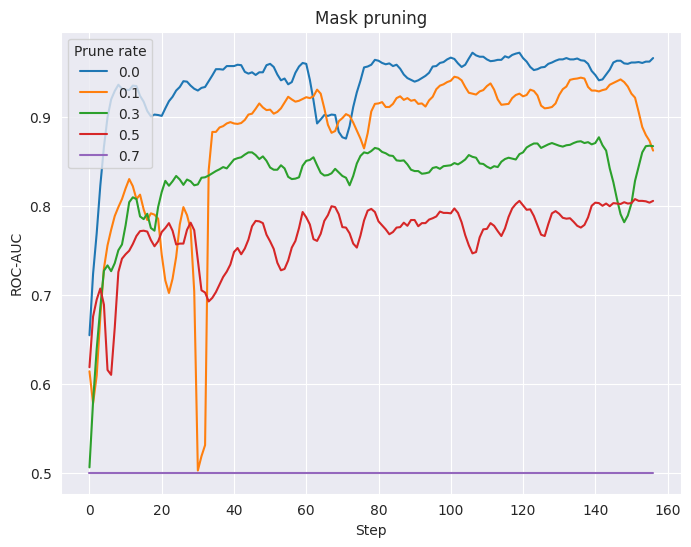

In [12]:
plt.figure(figsize=(8, 6))

for prune_rate, metric in zip(prune_rate_grid, history):
    plt.plot(metric, label=prune_rate)

plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Mask pruning')

In [10]:
history = []

# Gate pruning
temp_grid = [1, 5, 10, 15]
threshold_grid = [0.6, 0.7, 0.8]
for temp in tqdm(temp_grid, desc='temp'):
    for threshold in tqdm(threshold_grid, desc='threshold'):
        pruned_model, _, _ = magnitude_structural_prune_resnet(model, use_scores=True, temp=temp, threshold_prob=threshold)
        history.append(
            train_loop(pruned_model, trainloader, testloader)
        )

temp:   0%|          | 0/4 [00:00<?, ?it/s]

threshold:   0%|          | 0/3 [00:00<?, ?it/s]

fc output
temperature = 1	threshold = 0.6	prune rate = 0.00


  0%|          | 0/157 [00:00<?, ?it/s]

fc output
temperature = 1	threshold = 0.7	prune rate = 0.00


  0%|          | 0/157 [00:00<?, ?it/s]

fc output
temperature = 1	threshold = 0.8	prune rate = 0.00


  0%|          | 0/157 [00:00<?, ?it/s]

threshold:   0%|          | 0/3 [00:00<?, ?it/s]

fc output
temperature = 5	threshold = 0.6	prune rate = 0.00


  0%|          | 0/157 [00:00<?, ?it/s]

fc output
temperature = 5	threshold = 0.7	prune rate = 0.10


  0%|          | 0/157 [00:00<?, ?it/s]

fc output
temperature = 5	threshold = 0.8	prune rate = 0.24


  0%|          | 0/157 [00:00<?, ?it/s]

threshold:   0%|          | 0/3 [00:00<?, ?it/s]

fc output
temperature = 10	threshold = 0.6	prune rate = 0.10


  0%|          | 0/157 [00:00<?, ?it/s]

fc output
temperature = 10	threshold = 0.7	prune rate = 0.27


  0%|          | 0/157 [00:00<?, ?it/s]

fc output
temperature = 10	threshold = 0.8	prune rate = 0.43


  0%|          | 0/157 [00:00<?, ?it/s]

threshold:   0%|          | 0/3 [00:00<?, ?it/s]

fc output
temperature = 15	threshold = 0.6	prune rate = 0.16


  0%|          | 0/157 [00:00<?, ?it/s]

fc output
temperature = 15	threshold = 0.7	prune rate = 0.37


  0%|          | 0/157 [00:00<?, ?it/s]

fc output
temperature = 15	threshold = 0.8	prune rate = 1.00


  0%|          | 0/157 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Gate pruning')

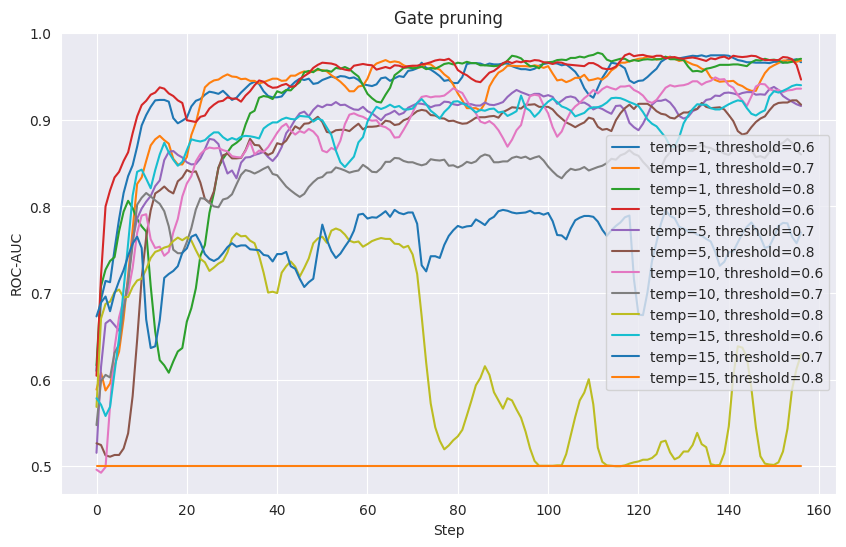

In [14]:
plt.figure(figsize=(10, 6))

i = 0
for temp in temp_grid:
    for threshold in threshold_grid:
        plt.plot(history[i], label=f'temp={temp}, threshold={threshold}')
        i += 1

plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.legend()
plt.title('Gate pruning')

Сравним порядок по качеству.

In [10]:
# Train full model and prepare for prune
full_model = copy.deepcopy(model)
train_loop(full_model, trainloader, testloader)
traced_graph = symbolic_trace(full_model)
make_gamma_hooks(full_model, traced_graph, lambda: SigmoidGamma(100.0))

# Prune and train model
pruned_model, conv_names, importance_scores = magnitude_structural_prune_resnet(model)
train_loop(pruned_model, trainloader, testloader)

  0%|          | 0/157 [00:00<?, ?it/s]

fc output
fc output


  0%|          | 0/157 [00:00<?, ?it/s]

In [65]:
# Some variables
num_samples = 1000
num_layers = len(conv_names)
qualities = []  # real quality after removing layer
pruning_scores = []  # importance from pruning algo

for _ in tqdm(range(num_samples), desc='sample'):
    scores = list(np.random.binomial(n=1, p=0.3, size=num_layers).astype(bool))  # random mask

    random_pruned_model = prune_layers_by_mask(full_model, scores, conv_names)  # randomly prune layers
    random_pruned_metric = test_loop(random_pruned_model, testloader)  # calculate quality
    
    magnitude_pruned_importance = (-importance_scores[scores]).mean()  # score from pruning algo
    
    qualities.append(random_pruned_metric)
    pruning_scores.append(magnitude_pruned_importance)

qualities = np.array(qualities)
pruning_scores = np.array(pruning_scores)

sample:   0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_36/4232558162.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  magnitude_pruned_importance = (-importance_scores[scores]).mean()  # score from pruning algo


Выделим невырожденные модели.

In [83]:
mask_qualities = qualities > 0.5
qualities_with_mask = qualities[mask_qualities]
pruning_scores_with_mask = pruning_scores[mask_qualities]

Построим графики для самопроверки.

Text(0, 0.5, 'Real qualities')

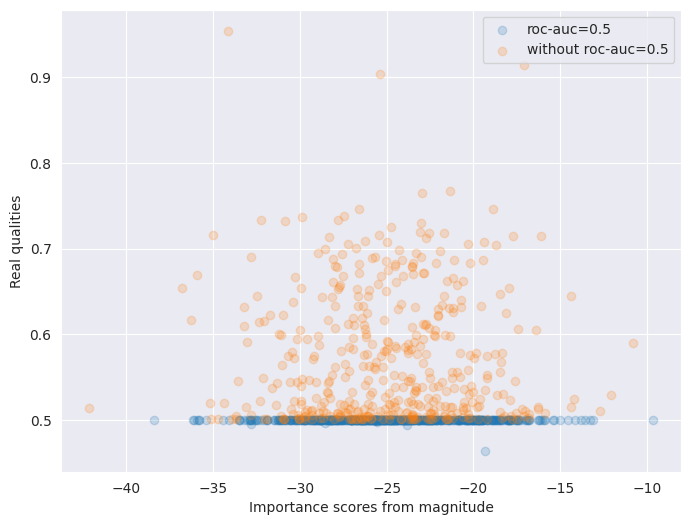

In [84]:
plt.figure(figsize=(8, 6))

plt.scatter(pruning_scores[~mask_qualities], qualities[~mask_qualities], alpha=0.2, label='roc-auc=0.5')
plt.scatter(pruning_scores_with_mask, qualities_with_mask, alpha=0.2, label='without roc-auc=0.5')

plt.legend()
plt.xlabel('Importance scores from magnitude')
plt.ylabel('Real qualities')

Проверим корреляции.

In [86]:
spearman_corr, _ = spearmanr(pruning_scores, qualities)
kendall_corr, _ = kendalltau(pruning_scores, qualities)
spearman_corr_mask, _ = spearmanr(pruning_scores_with_mask, qualities_with_mask)
kendall_corr_mask, _ = kendalltau(pruning_scores_with_mask, qualities_with_mask)

print(f"Spearman:\t{spearman_corr:.5f}")
print(f"Kendall:\t{kendall_corr:.5f}")
print(f"Spearman mask:\t{spearman_corr_mask:.5f}")
print(f"Kendall mask:\t{kendall_corr_mask:.5f}")

Spearman:	-0.01702
Kendall:	-0.01274
Spearman mask:	0.01558
Kendall mask:	0.01065


### Прунинг по Молчанову

Посмотрим на зависимость метрики от процента прунинга. Попробуем также прунинг с гейтами.

In [26]:
history = []

# Mask pruning
prune_rate_grid = np.append(np.linspace(0, 0.1, 3), np.linspace(0.9, 1, 3))  # mirror check
for prune_rate in tqdm(prune_rate_grid, desc='prune rate'):
    pruned_model, _, _ = taylor_structural_prune_resnet(model, trainloader, prune_rate=prune_rate)
    history.append(
        train_loop(pruned_model, trainloader, testloader)
    )

prune rate:   0%|          | 0/6 [00:00<?, ?it/s]

fc output
fc output


  0%|          | 0/157 [00:00<?, ?it/s]

fc output
fc output


  0%|          | 0/157 [00:00<?, ?it/s]

fc output
fc output


  0%|          | 0/157 [00:00<?, ?it/s]

fc output
fc output


  0%|          | 0/157 [00:00<?, ?it/s]

fc output
fc output


  0%|          | 0/157 [00:00<?, ?it/s]

fc output
fc output


  0%|          | 0/157 [00:00<?, ?it/s]

Построим графики.

Text(0.5, 1.0, 'Mask pruning')

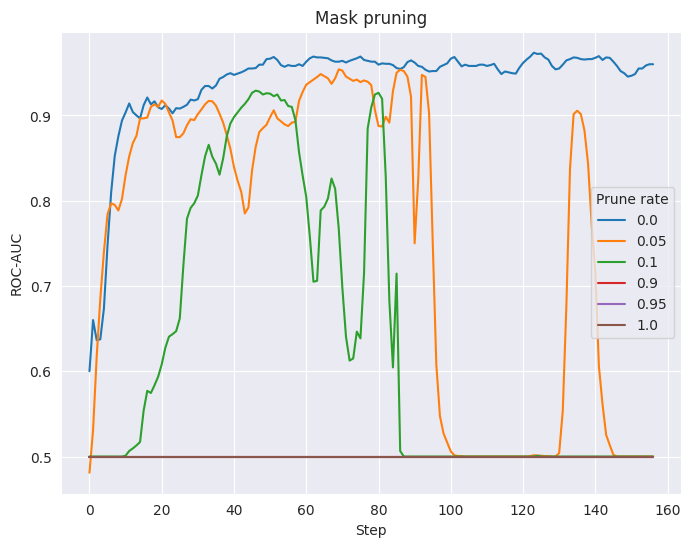

In [27]:
plt.figure(figsize=(8, 6))

for prune_rate, metric in zip(prune_rate_grid, history):
    plt.plot(metric, label=prune_rate)

plt.legend(title='Prune rate')
plt.xlabel('Step')
plt.ylabel('ROC-AUC')
plt.title('Mask pruning')

Сравним порядок по качеству.

In [11]:
# Train full model and prepare for prune
full_model = copy.deepcopy(model)
train_loop(full_model, trainloader, testloader)
traced_graph = symbolic_trace(full_model)
make_gamma_hooks(full_model, traced_graph, lambda: SigmoidGamma(100.0))

# Prune and train model
pruned_model, conv_names, importance_scores = taylor_structural_prune_resnet(model, trainloader)
train_loop(pruned_model, trainloader, testloader)

  0%|          | 0/157 [00:00<?, ?it/s]

fc output
fc output
fc output


  0%|          | 0/157 [00:00<?, ?it/s]

[0.556,
 0.603,
 0.5035,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5025,
 0.5245,
 0.568,
 0.613,
 0.626,
 0.642,
 0.645,
 0.648,
 0.657,
 0.6615,
 0.661,
 0.657,
 0.6695,
 0.6825,
 0.701,
 0.732,
 0.7595,
 0.7945,
 0.818,
 0.845,
 0.8665,
 0.877,
 0.88,
 0.884,
 0.8955,
 0.901,
 0.9095,
 0.906,
 0.898,
 0.9005,
 0.901,
 0.899,
 0.906,
 0.9245,
 0.93,
 0.928,
 0.9225,
 0.921,
 0.9145,
 0.9085,
 0.903,
 0.8925,
 0.864,
 0.8515,
 0.8215,
 0.811,
 0.8315,
 0.84,
 0.836,
 0.811,
 0.775,
 0.727,
 0.662,
 0.6195,
 0.6025,
 0.591,
 0.5855,
 0.5725,
 0.561,
 0.5455,
 0.5295,
 0.5095,
 0.504,
 0.5135,
 0.6115,
 0.665,
 0.761,
 0.8425,
 0.6605,
 0.549,
 0.5275,
 0.5545,
 0.6085,
 0.6355,
 0.588,
 0.5235,
 0.501,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5015,
 0.5665,
 0.7855,
 0.8145,
 0.908,
 0.885,
 0.9065,
 0.903,
 0.8355,
 0.8515,
 0.8,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,


In [12]:
# Some variables
num_samples = 50  # gpu out of memory :(
num_layers = len(conv_names)
qualities = []  # real quality after removing layer
pruning_scores = []  # importance from pruning algo
importance_scores = np.array(importance_scores)

for _ in tqdm(range(num_samples), desc='sample'):
    scores = list(np.random.binomial(n=1, p=0.1, size=num_layers).astype(bool))  # random mask

    random_pruned_model = prune_layers_by_mask(full_model, scores, conv_names)  # randomly prune layers
    random_pruned_metric = test_loop(random_pruned_model, testloader)  # calculate quality
    
    taylor_pruned_importance = (-importance_scores[scores]).mean()  # score from pruning algo
    
    qualities.append(random_pruned_metric)
    pruning_scores.append(taylor_pruned_importance)

qualities = np.array(qualities)
pruning_scores = np.array(pruning_scores)

sample:   0%|          | 0/50 [00:00<?, ?it/s]

Выделим невырожденные модели.

In [13]:
mask_qualities = qualities > 0.5
qualities_with_mask = qualities[mask_qualities]
pruning_scores_with_mask = pruning_scores[mask_qualities]

Построим графики для самопроверки.

Text(0, 0.5, 'Real qualities')

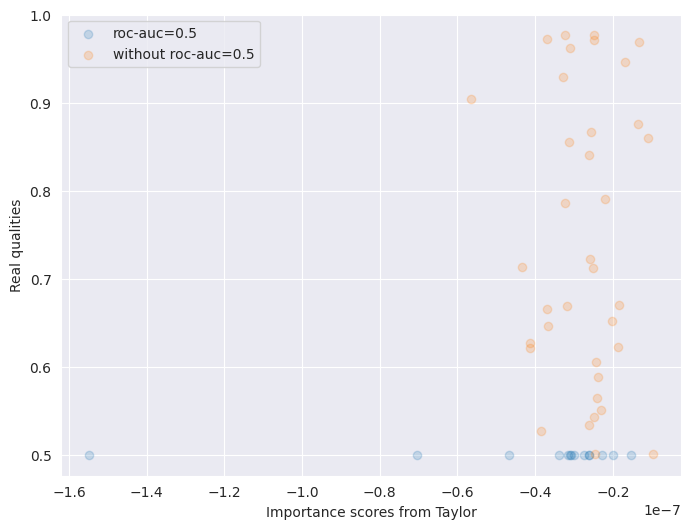

In [14]:
plt.figure(figsize=(8, 6))

plt.scatter(pruning_scores[~mask_qualities], qualities[~mask_qualities], alpha=0.2, label='roc-auc=0.5')
plt.scatter(pruning_scores_with_mask, qualities_with_mask, alpha=0.2, label='without roc-auc=0.5')

plt.legend()
plt.xlabel('Importance scores from Taylor')
plt.ylabel('Real qualities')

Проверим корреляции.

In [15]:
spearman_corr, _ = spearmanr(pruning_scores, qualities)
kendall_corr, _ = kendalltau(pruning_scores, qualities)
spearman_corr_mask, _ = spearmanr(pruning_scores_with_mask, qualities_with_mask)
kendall_corr_mask, _ = kendalltau(pruning_scores_with_mask, qualities_with_mask)

print(f"Spearman:\t{spearman_corr:.5f}")
print(f"Kendall:\t{kendall_corr:.5f}")
print(f"Spearman mask:\t{spearman_corr_mask:.5f}")
print(f"Kendall mask:\t{kendall_corr_mask:.5f}")

Spearman:	0.10366
Kendall:	0.08743
Spearman mask:	-0.06474
Kendall mask:	-0.02383
